# Importation des librairies et analyse descriptive

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix


# Importation et Visualisation des données

|Fichier                             |Lignes  |Colonnes  |Description                                             |
|------------------------------------|--------|----------|--------------------------------------------------------|
| matchs_2013_2022.csv               | 4078   | 23       | Historique des matchs avec résultats (2013–2022)       |
| match_2023.csv                     | 270    | 12       | Matchs à prédire (pas de résultats)                    |
| player_appearance.csv              | 115182 | 13       | Performances des joueurs par match                     |
| player_valuation_before_season.csv | 30215  | 5        | Valeur estimée des joueurs avant les saisons           |
| game_lineups.csv                   | 137132 | 11       | Composition des équipes par match                      |
| game_events.csv                    | ≈      | ≈        | Actions des joueurs pendant les matchs                 |
| sample_results.csv                 | 270    | 2        | Format attendu pour la prédiction (match_id, résultat) |

In [73]:
# Importation des csv et visualisation des informations
df_matches = pd.read_csv("matchs_2013_2022.csv")
print("\nInfo matches")
df_matches.info()
print("\n[HEAD]")
print(df_matches.head())

df_predict = pd.read_csv("match_2023.csv")
print("\nInfo predict")
df_predict.info()
print("\n[HEAD]")
print(df_predict.head())

df_player_app = pd.read_csv("player_appearance.csv")
print("\nInfo player app")
df_player_app.info()
print("\n[HEAD]")
print(df_player_app.head())
    
df_player_val = pd.read_csv("player_valuation_before_season.csv")
print("\nInfo player val")
df_player_val.info()
print("\n[HEAD]")
print(df_player_val.head())
    
df_clubs = pd.read_csv("clubs_fr.csv")
print("\nInfo clubs")
df_clubs.info()
print("\n[HEAD]")
print(df_clubs.head())

df_events = pd.read_csv("game_events.csv")
print("\nInfo events")
df_events.info()
print("\n[HEAD]")
print(df_events.head())

df_result = pd.read_csv("sample_results.csv")
print("\n[INFO]")
df_result.info()

# Analyser la distribution de la variable cible 'results'
print("Distribution de la variable cible (results) :")
print(df_matches['results'].value_counts(normalize=True))


Info matches
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              4078 non-null   int64  
 1   game_id                 4078 non-null   int64  
 2   season                  4078 non-null   int64  
 3   round                   4078 non-null   object 
 4   date                    4078 non-null   object 
 5   home_club_id            4078 non-null   int64  
 6   away_club_id            4078 non-null   int64  
 7   home_club_goals         4078 non-null   int64  
 8   away_club_goals         4078 non-null   int64  
 9   home_club_position      4078 non-null   float64
 10  away_club_position      4078 non-null   float64
 11  home_club_manager_name  4078 non-null   object 
 12  away_club_manager_name  4078 non-null   object 
 13  stadium                 4078 non-null   object 
 14  attendance              37

## Visualisation

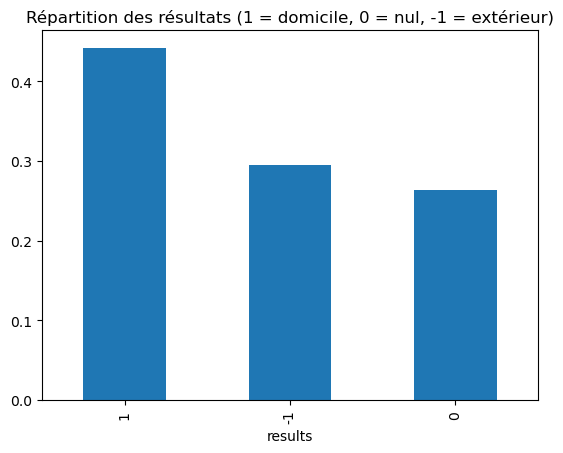

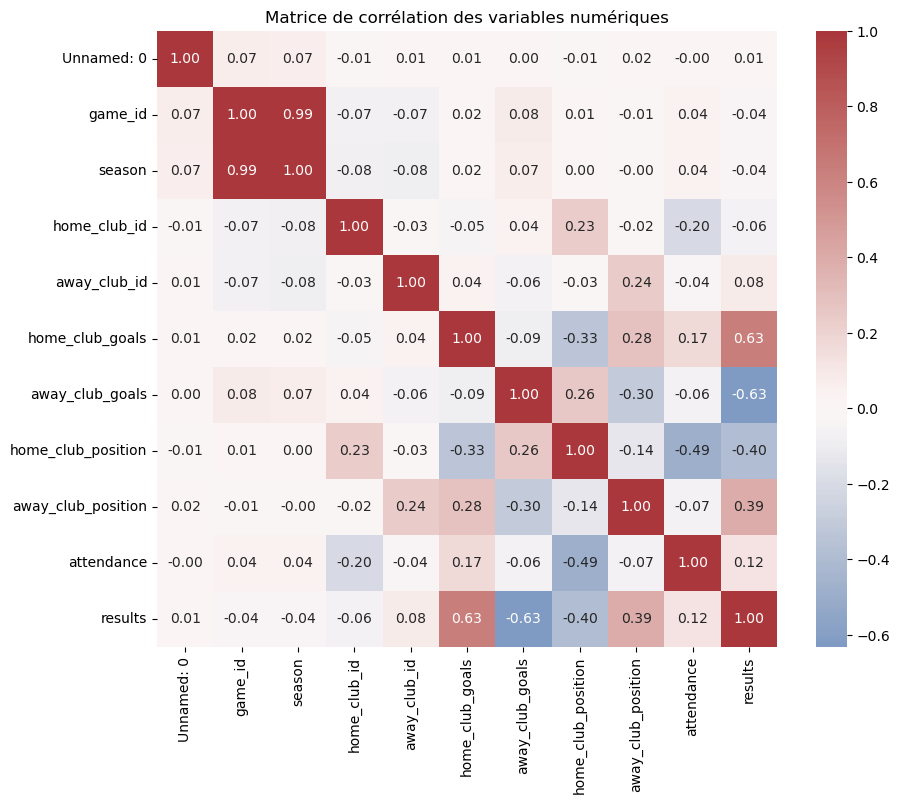

In [74]:

df_matches['results'].value_counts(normalize=True).plot(kind='bar')
plt.title("Répartition des résultats (1 = domicile, 0 = nul, -1 = extérieur)")
plt.show()

## Matrice de corrélation (Correction : Remplacer 'hist' par 'df_matches_cleaned')
num_cols = df_matches.select_dtypes(include='number').columns
corr = df_matches[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

## Points clés observés¶
- Fuite de données : les variables "home_club_goals" et "away_club_goals" sont fortement corrélées à la cible (results), constituant une fuite d’information à exclure du jeu de features.
- Corrélation de l’affluence : coefficient < 0.2, impact limité sur la prédiction, mais présence de valeurs extrêmes (outliers) à gérer.
- Distribution asymétrique des variables continues : affluence et valeur marchande des joueurs présentent une forte skewness, nécessitant un prétraitement de type log-scaling.

# Pré-traitement des Données (Preprocessing)


## Match

In [75]:
df_matches_cleaned = df_matches.copy()
df_predict_cleaned = df_predict.copy()

# 1. Conversion des dates
df_matches_cleaned['date'] = pd.to_datetime(df_matches_cleaned['date'])
df_predict_cleaned['date'] = pd.to_datetime(df_predict_cleaned['date'])

# 2. Ajout de la saison "2023" dans le df_predict_cleaned
df_predict_cleaned['season'] = 2023

# 3. Ajout de valeurs dans attendance
median_attendance = df_matches_cleaned['attendance'].median()
df_matches_cleaned['attendance'] = df_matches_cleaned['attendance'].fillna(median_attendance)
df_predict_cleaned['attendance'] = df_predict_cleaned['attendance'].fillna(median_attendance)

# 4. Ajout de valeurs dans formations
df_matches_cleaned['home_club_formation'] = df_matches_cleaned['home_club_formation'].fillna('Inconnu')
df_matches_cleaned['away_club_formation'] = df_matches_cleaned['away_club_formation'].fillna('Inconnu')

# Colonnes à supprimer de l'entraînement
cols_to_drop_train = [
    'Unnamed: 0', 'home_club_goals', 'away_club_goals',
    'home_club_position', 'away_club_position',
    'round', 'aggregate', 'date',
    'home_club_manager_name', 'away_club_manager_name', 
    'stadium', 'referee', 'home_club_name', 'away_club_name',
    'competition_type', 'home_club_formation', 'away_club_formation'
]

# Colonnes à supprimer de la prédiction
cols_to_drop_predict = [
    'date', 'home_club_manager_name', 'away_club_manager_name',
    'stadium', 'referee', 'home_club_name', 'away_club_name',
    'competition_type'
]

# Application de la suppression
df_matches_cleaned = df_matches_cleaned.drop(columns=cols_to_drop_train, errors='ignore')
df_predict_cleaned = df_predict_cleaned.drop(columns=cols_to_drop_predict, errors='ignore')
print(df_matches_cleaned.head(), "\n\n\n", df_predict_cleaned.head())




   game_id  season  home_club_id  away_club_id  attendance  results
0  2330874    2013           618           595     31952.0        0
1  2330880    2013         14171           855      8620.0       -1
2  2330916    2013          1423          1082     14874.0       -1
3  2331018    2013           273         14171     13391.0        0
4  2331034    2013          1147           273      5981.0        1 


    game_id  home_club_id  away_club_id  attendance  season
0  4094596           583           826     47000.0    2023
1  4094622           826           347     37988.0    2023
2  4094630           969           273     15430.0    2023
3  4094647           347           417     23160.0    2023
4  4094696           244           273     54162.0    2023


## Joueurs

In [76]:
# 1. Sélectionner uniquement les colonnes utiles dès le départ
cols_a_garder_joueur = [
    'game_id', 'player_id', 'player_club_id', 'date', 
    'minutes_played', 'yellow_cards', 'red_cards' 
]
df_app_clean = df_player_app.copy()

df_app_clean = df_app_clean[cols_a_garder_joueur]

# 2. Conversion date
df_app_clean['date'] = pd.to_datetime(df_app_clean['date'])
df_app_clean['season'] = df_app_clean['date'].apply(lambda x: x.year if x.month >= 8 else x.year - 1)

# 3. Supprimer les joueurs qui n'ont pas joué (minutes = 0)
df_app_clean = df_app_clean[df_app_clean['minutes_played'] > 0]
df_app_clean.head()

,game_id,player_id,player_club_id,date,minutes_played,yellow_cards,red_cards,season
0,2229837,108830,415,2012-08-10,90,1,0,2012
1,2229837,113707,969,2012-08-10,42,1,0,2012
2,2229837,126767,415,2012-08-10,90,0,0,2012
3,2229837,126796,415,2012-08-10,11,0,1,2012
4,2229837,127032,415,2012-08-10,84,0,1,2012


In [77]:
df_val_clean = df_player_val.copy()

# 1. Conversion en datetime
df_val_clean['date'] = pd.to_datetime(df_val_clean['date'])

# 2. Extraction de la saison
df_val_clean['season'] = df_val_clean['date'].dt.year

# 3. Gestion des doublons (Gardons la dernière valuation connue pour la saison)
# On trie par date et on garde la dernière occurrence pour chaque couple (player_id, season)
df_val_clean = df_val_clean.sort_values('date').drop_duplicates(
    subset=['player_id', 'season'], 
    keep='last'
)

cols_to_keep_val = ['player_id', 'season', 'market_value_in_eur']
df_val_clean = df_val_clean[cols_to_keep_val]

# Reset index pour être propre
df_val_clean = df_val_clean.reset_index(drop=True)
df_val_clean.head()

,player_id,season,market_value_in_eur
0,773,2004,3500000
1,12508,2004,250000
2,12503,2004,2500000
3,12386,2004,1250000
4,12379,2004,2500000


## Clubs

In [78]:
# 2. Sélection des colonnes pertinentes
# On ne garde que l'ID  et la capacité du stade
cols_clubs_to_keep = ['club_id', 'stadium_seats']
df_clubs_clean = df_clubs[cols_clubs_to_keep].copy()

df_clubs_clean.head()

,club_id,stadium_seats
0,969,32939
1,1082,50186
2,1160,8033
3,3911,15220
4,595,16480


## Events

In [79]:
cols_events_to_keep = ['game_id', 'club_id', 'type', 'description']
df_events_clean = df_events[cols_events_to_keep].copy()

# Analyse de description et création de nouvelles colonnes
df_events_clean['jaune'] = df_events_clean['description'].str.contains('Yellow', na=False).astype(int)
df_events_clean['rouge'] = df_events_clean['description'].str.contains('Red', na=False).astype(int)
df_events_clean['but']   = (df_events_clean['type'] == 'Goals').astype(int)

df_events_clean = df_events_clean[['game_id', 'club_id','jaune', 'rouge', 'but']]
df_events_clean.head()

,game_id,club_id,jaune,rouge,but
0,2223841,3911,0,0,0
1,2223841,3911,0,0,1
2,2223841,3911,0,0,0
3,2223841,1423,1,0,0
4,2223841,1423,1,0,0


## Merge Total

In [80]:
# Fusionner Apparitions et Valeurs
df_joueurs_complet = pd.merge(
    df_app_clean,
    df_val_clean,
    on=['player_id', 'season'],
    how='left'
)

df_joueurs_complet['market_value_in_eur'] = df_joueurs_complet['market_value_in_eur'].fillna(0)

# Grouper par Match et par Club 
df_team_valuations = df_joueurs_complet.groupby(['game_id', 'player_club_id'])['market_value_in_eur'].mean().reset_index()
df_team_valuations.columns = ['game_id', 'club_id', 'team_avg_value']

print("Stats financières prêtes :", df_team_valuations.shape[0])
df_team_valuations.head()

Stats financières prêtes : 8156


,game_id,club_id,team_avg_value
0,2223841,1423,8.750000e+05
1,2223841,3911,1.500000e+06
2,2223842,1147,6.923077e+05
3,2223842,3911,1.428571e+06
4,2223843,1159,4.583333e+05


In [81]:
# Grouper par Match et Club
# On fait la somme des cartons et buts pour chaque équipe dans chaque match
df_team_events = df_events_clean.groupby(['game_id', 'club_id'])[['jaune', 'rouge', 'but']].sum().reset_index()

df_team_events.columns = ['game_id', 'club_id', 'nb_jaunes', 'nb_rouges', 'nb_buts_history']

print("Stats événements prêtes :", df_team_events.shape[0])
df_team_events.head()

Stats événements prêtes : 8152


,game_id,club_id,nb_jaunes,nb_rouges,nb_buts_history
0,2223841,1423,2,1,1
1,2223841,3911,2,0,2
2,2223842,1147,1,0,1
3,2223842,3911,2,0,0
4,2223843,1159,1,0,0


In [82]:
# Fusionner Valuations et Events sur [game_id, club_id]
df_team_features = pd.merge(
    df_team_valuations,
    df_team_events,
    on=['game_id', 'club_id'],
    how='outer' 
)

# Remplir les NaN par 0 
df_team_features = df_team_features.fillna(0)

df_team_features.head()

,game_id,club_id,team_avg_value,nb_jaunes,nb_rouges,nb_buts_history
0,2223841,1423,8.750000e+05,2.0,1.0,1.0
1,2223841,3911,1.500000e+06,2.0,0.0,2.0
2,2223842,1147,6.923077e+05,1.0,0.0,1.0
3,2223842,3911,1.428571e+06,2.0,0.0,0.0
4,2223843,1159,4.583333e+05,1.0,0.0,0.0


In [83]:
# 1. Ajouter les Stades (Clubs)
df_final_train = pd.merge(
    df_matches_cleaned,
    df_clubs_clean[['club_id', 'stadium_seats']],
    left_on='home_club_id',
    right_on='club_id',
    how='left'
).rename(columns={'stadium_seats': 'stadium_capacity'}).drop(columns=['club_id'])

# 2. Ajouter les Stats HOME
df_final_train = pd.merge(
    df_final_train,
    df_team_features,
    left_on=['game_id', 'home_club_id'],
    right_on=['game_id', 'club_id'],
    how='left'
)

df_final_train = df_final_train.rename(columns={
    'team_avg_value': 'home_value',
    'nb_jaunes': 'home_jaunes',     
    'nb_rouges': 'home_rouges',   
    'nb_buts_history': 'home_buts' 
}).drop(columns=['club_id'])

# 3. Ajouter les Stats AWAY
df_final_train = pd.merge(
    df_final_train,
    df_team_features,
    left_on=['game_id', 'away_club_id'],
    right_on=['game_id', 'club_id'],
    how='left'
)

df_final_train = df_final_train.rename(columns={
    'team_avg_value': 'away_value',
    'nb_jaunes': 'away_jaunes',    
    'nb_rouges': 'away_rouges',
    'nb_buts_history': 'away_buts'
}).drop(columns=['club_id'])

#Nettoyage
cols_leakage = [
    'home_buts', 'away_buts', 
    'home_jaunes', 'away_jaunes',
    'home_rouges', 'away_rouges'  
]

df_final_train = df_final_train.drop(columns=cols_leakage, errors='ignore')

# Remplissage des NaN restants
cols_num = df_final_train.select_dtypes(include=['int64', 'float64']).columns
df_final_train[cols_num] = df_final_train[cols_num].fillna(0)

# Vérification
print("Colonnes restantes pour la prédiction :")
print(df_final_train.columns.tolist())
df_final_train.head()

Colonnes restantes pour la prédiction :
['game_id', 'season', 'home_club_id', 'away_club_id', 'attendance', 'results', 'stadium_capacity', 'home_value', 'away_value']


,game_id,season,home_club_id,away_club_id,attendance,results,stadium_capacity,home_value,away_value
0,2330874,2013,618,595,31952.0,0,42000,2.678571e+06,1.214286e+06
1,2330880,2013,14171,855,8620.0,-1,2500,5.785714e+05,5.250000e+05
2,2330916,2013,1423,1082,14874.0,-1,25000,6.285714e+05,2.107143e+06
3,2331018,2013,273,14171,13391.0,0,29778,1.864286e+06,4.178571e+05
4,2331034,2013,1147,273,5981.0,1,10446,6.714286e+05,1.592857e+06


In [84]:
# Ajouter les Stades
df_final_predict = pd.merge(
    df_predict_cleaned,
    df_clubs_clean[['club_id', 'stadium_seats']],
    left_on='home_club_id',
    right_on='club_id',
    how='left'
).rename(columns={'stadium_seats': 'stadium_capacity'}).drop(columns=['club_id'])

# Ajouter les Stats home
df_final_predict = pd.merge(
    df_final_predict,
    df_team_features,
    left_on=['game_id', 'home_club_id'],
    right_on=['game_id', 'club_id'],
    how='left'
).rename(columns={
    'team_avg_value': 'home_value',
    'nb_jaunes': 'home_jaunes',
    'nb_rouges': 'home_rouges',
    'nb_buts_history': 'home_buts_hist'
}).drop(columns=['club_id'])

# Ajouter les Stats away
df_final_predict = pd.merge(
    df_final_predict,
    df_team_features,
    left_on=['game_id', 'away_club_id'],
    right_on=['game_id', 'club_id'],
    how='left'
).rename(columns={
    'team_avg_value': 'away_value',
    'nb_jaunes': 'away_jaunes',
    'nb_rouges': 'away_rouges',
    'nb_buts_history': 'away_buts_hist'
}).drop(columns=['club_id'])

# Nettoyage final
cols_num = df_final_predict.select_dtypes(include=['int64', 'float64']).columns
df_final_predict[cols_num] = df_final_predict[cols_num].fillna(0)
df_final_predict.shape
df_final_predict.head()

,game_id,home_club_id,away_club_id,attendance,season,stadium_capacity,home_value,home_jaunes,home_rouges,home_buts_hist,away_value,away_jaunes,away_rouges,away_buts_hist
0,4094596,583,826,47000.0,2023,49691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4094622,826,347,37988.0,2023,38223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4094630,969,273,15430.0,2023,32939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4094647,347,417,23160.0,2023,28786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4094696,244,273,54162.0,2023,67394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Formalisation du Problème
##### Objectif : Développer un modèle prédictif capable d'anticiper l'issue des matchs de football de la saison 2023 en se basant sur l'historique des données 2013-2022.
## Définition du Problème : 
Nous sommes face à un problème de Classification Supervisée Multiclasse.

La variable à prédire est results, qui peut prendre 3 valeurs discrètes :
- $1$ : Victoire de l'équipe à Domicile
- $0$ : Match Nul
- $-1$ : Victoire de l'équipe à l'Extérieur

## Construction de l'Espace des Features 
Nous construisons notre espace de features sur 2 dimensions principales :
- A. Dimension Structurelle & Financière (Static)
  - club_valuation : Valeur marchande totale de l'effectif.
  - starter_value : Valeur cumulée du 11 de départ probable (plus précis que la valeur globale).
  - stadium_capacity : Proxy de l'avantage à domicile et de la pression du public.

- B. Dimension Contextuelle
  - season : Pour capter les tendances annuelles.
  - attendance : Affluence réelle (imputée par la médiane si manquante).

## Stratégie d'Évaluation
Pour valider la pertinence de notre approche, nous utiliserons les métriques suivantes :

- Accuracy (Précision globale) : Pour une vue d'ensemble simple.

- F1-Score Weighted (Métrique Principale) : La moyenne harmonique de la précision et du rappel, pondérée par le support de chaque classe. C'est la métrique la plus robuste pour ce problème déséquilibré.

- Matrice de Confusion : Pour analyser spécifiquement la capacité du modèle à prédire les matchs nuls.

## Pipeline de Modélisation

- Baseline (Référence) : Régression Logistique.

  - Avantage : Simple, interprétable, rapide.
- Random Forest

In [85]:
# y = la colonne cible
y = df_final_train['results']

# X = toutes les colonnes explicatives
X = df_final_train.drop(columns=['results'])

# Split du jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

### modèle le plus simple (prédiction des matchs nuls)

In [86]:
y_pred_baseline = np.zeros_like(y_test)

print("Accuracy :", accuracy_score(y_test, y_pred_baseline))
print("F1-macro :", f1_score(y_test, y_pred_baseline, average='macro'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion matrix:\n", cm)

Accuracy : 0.26286764705882354
F1-macro : 0.13876758854924795

Confusion matrix:
 [[  0 482   0]
 [  0 429   0]
 [  0 721   0]]


### Logistic Regression Multinomial

Logistic Regression:
Accuracy: 0.4852941176470588
F1-macro: 0.33150380250921113

Classification report:
               precision    recall  f1-score   support

          -1       0.49      0.28      0.36       482
           0       1.00      0.00      0.00       429
           1       0.48      0.91      0.63       721

    accuracy                           0.49      1632
   macro avg       0.66      0.40      0.33      1632
weighted avg       0.62      0.49      0.39      1632


Confusion matrix:



/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


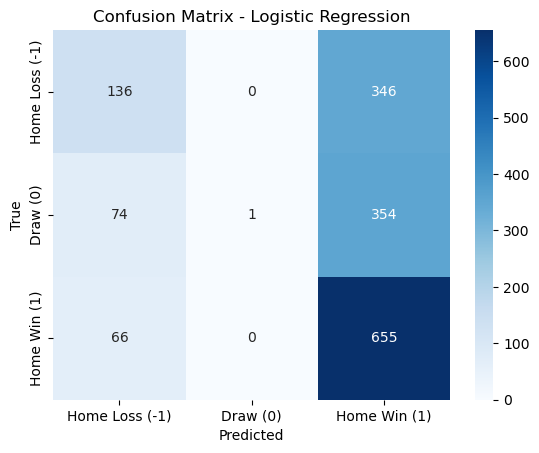

In [87]:
# Logistic Regression baseline model
logreg = LogisticRegression(max_iter=500, multi_class='multinomial')
logreg.fit(X_train, y_train)

# Predictions
y_pred_lr = logreg.predict(X_test)

# Evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-macro:", f1_score(y_test, y_pred_lr, average='macro'))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion matrix:\n")

sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Home Loss (-1)', 'Draw (0)', 'Home Win (1)'],
            yticklabels=['Home Loss (-1)', 'Draw (0)', 'Home Win (1)'])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Logistic Regression Balanced

Logistic Regression:
Accuracy: 0.4332107843137255
F1-macro: 0.40654304784550005

Classification report:
               precision    recall  f1-score   support

          -1       0.40      0.58      0.48       482
           0       0.26      0.21      0.23       429
           1       0.57      0.47      0.51       721

    accuracy                           0.43      1632
   macro avg       0.41      0.42      0.41      1632
weighted avg       0.44      0.43      0.43      1632


Confusion matrix:



/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


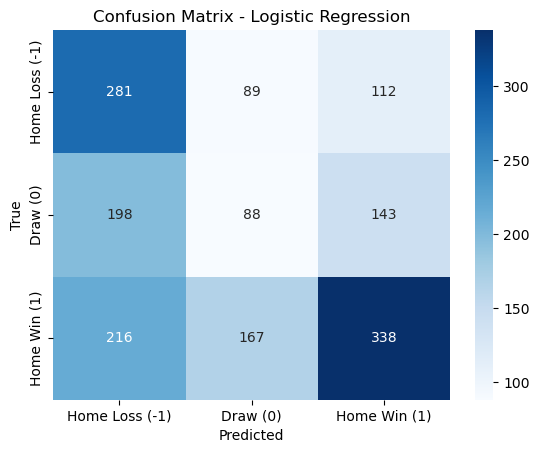

In [89]:
# Logistic Regression baseline model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions
y_pred_lr = logreg.predict(X_test)

# Evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-macro:", f1_score(y_test, y_pred_lr, average='macro'))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion matrix:\n")

sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Home Loss (-1)', 'Draw (0)', 'Home Win (1)'],
            yticklabels=['Home Loss (-1)', 'Draw (0)', 'Home Win (1)'])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Random Forest

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs Paramètres trouvés : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Meilleur Score F1-Macro (Validation) : 0.4290420035792894

Performance du Modèle Optimisé
Accuracy : 0.45526960784313725
F1-macro : 0.41889111591140815

Confusion Matrix :


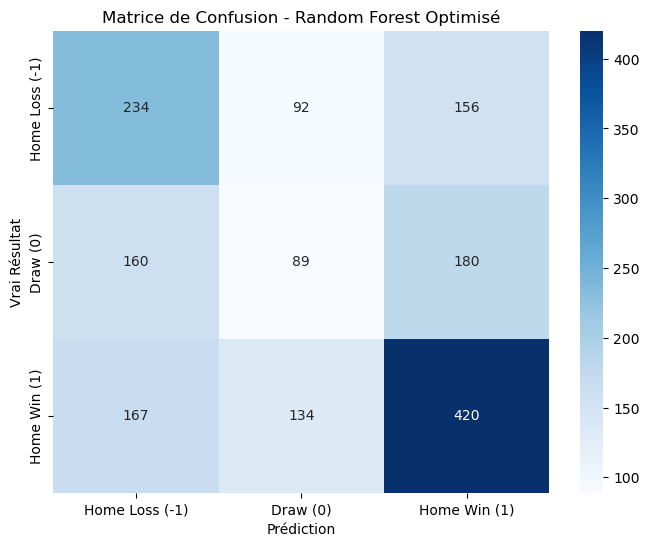

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1. Définir le modèle de base
# On garde class_weight='balanced' pour aider à détecter les nuls
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 2. paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 500],     
    'max_depth': [10, 20, None],        
    'min_samples_split': [2, 5, 10]    
}

# 3. Lancer la recherche (Fine-Tuning)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 4. Résultats du Tuning
print("Meilleurs Paramètres trouvés :", grid_search.best_params_)
print("Meilleur Score F1-Macro (Validation) :", grid_search.best_score_)

# 5. Utiliser le meilleur modèle pour prédire
best_model = grid_search.best_estimator_
y_pred_opti = best_model.predict(X_test)

# 6. Évaluation Finale (Correction des variables)
print("\nPerformance du Modèle Optimisé")
print("Accuracy :", accuracy_score(y_test, y_pred_opti))
print("F1-macro :", f1_score(y_test, y_pred_opti, average='macro'))

print("\nConfusion Matrix :")
cm_opti = confusion_matrix(y_test, y_pred_opti)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opti, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Home Loss (-1)', 'Draw (0)', 'Home Win (1)'],
            yticklabels=['Home Loss (-1)', 'Draw (0)', 'Home Win (1)'])
plt.title("Matrice de Confusion - Random Forest Optimisé")
plt.ylabel('Vrai Résultat')
plt.xlabel('Prédiction')
plt.show()